In [292]:
import warnings
warnings.filterwarnings('always') 

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from pprint import pprint
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [293]:
data_x, data_target = load_iris(return_X_y=True, as_frame=True)
cols_iris = {'sepal length (cm)': 'sl',
             'sepal width (cm)': 'sw',
             'petal length (cm)': 'pl',
             'petal width (cm)': 'pw'}
data_x =data_x.rename(columns=cols_iris)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_target, test_size=0.3, random_state=43)
data_train=X_train.join(y_train)
data_test=X_test.join(y_test)


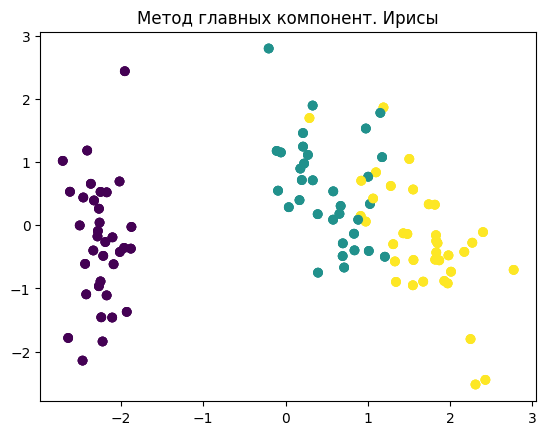

Информативность: 95.98%
[[ 0.52465916 -0.25004775  0.58180886  0.56895285]
 [-0.36738691 -0.92845041 -0.01663093 -0.0522504 ]
 [-0.73002103  0.25137012  0.16660771  0.61328968]
 [ 0.23838819 -0.11076558 -0.79590435  0.54537906]]


In [294]:
scaler = StandardScaler()

data_train_scaled = scaler.fit_transform(X_train)
data_test_scaled = scaler.fit_transform(X_test)
pca = PCA()
x_pca = pca.fit_transform(data_train_scaled)
x_test_pca = pca.transform(data_test_scaled)

data_delta = pca.explained_variance_ratio_
x_pca_pd = pd.DataFrame(x_pca, columns=['f1', 'f2', 'f3', 'f4'])
x_test_pca_pd = pd.DataFrame(x_test_pca, columns=['f1', 'f2', 'f3', 'f4'])

for i in range(3):
    plt.scatter(data=x_pca_pd, x='f1', y='f2', c=y_train)
    
plt.title('Метод главных компонент. Ирисы')
plt.show()
print(f'Информативность: {100*sum(data_delta[:2]):.2f}%')
print(pca.components_)

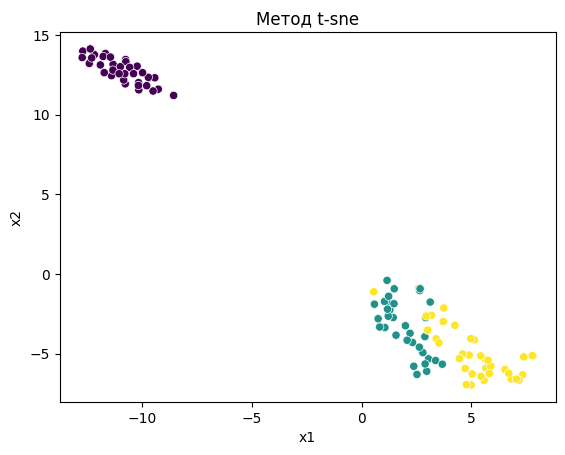

In [295]:
t_sne = TSNE()
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_train_scaled)
tsne_data =pd.DataFrame(tsne_data,columns=['x1','x2'])
sns.scatterplot(data=tsne_data, x='x1', y='x2', c=y_train)
plt.title('Метод t-sne')
plt.show()

По данным представлениям, можно сказать, что один класс точно можно хорошо выделить. А два другие класса можно различить, но не для каждого наблюдения. По методу главных компонент визуально можно сказать, что данные можно неплохо разделить линейно, но они не являются линейно разделимыми.

Средние метрики для валидационных выборок
test_accuracy           0.935000
test_recall_micro       0.935000
test_recall_macro       0.941667
test_precision_micro    0.935000
test_precision_macro    0.955556
test_f1_micro           0.935000
test_f1_macro           0.933333
dtype: float64 

Метрики по тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      0.84      0.89        19
           2       0.77      0.91      0.83        11

    accuracy                           0.91        45
   macro avg       0.90      0.92      0.91        45
weighted avg       0.92      0.91      0.91        45



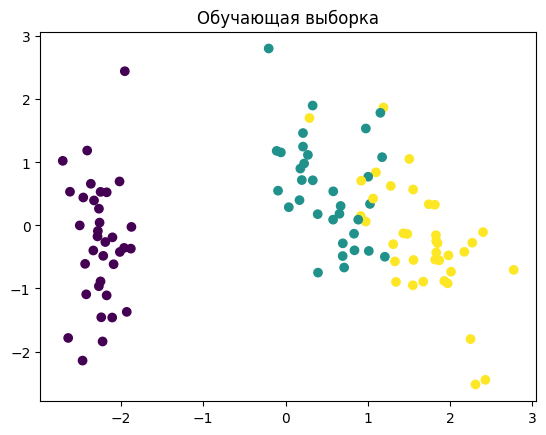

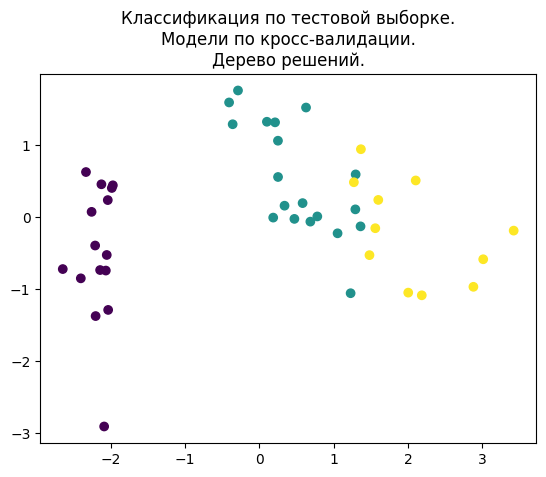

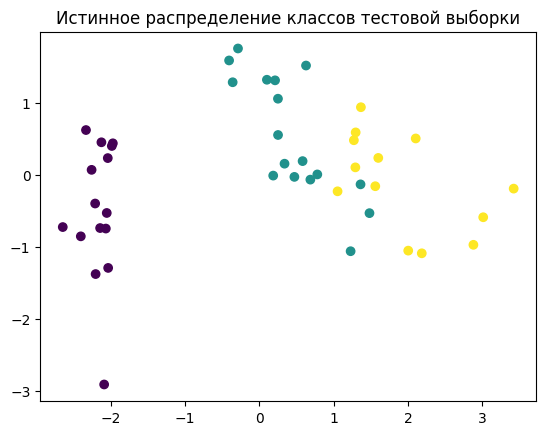

In [296]:
from sklearn.metrics import classification_report

scores1 = ['accuracy', 'recall_micro', 'recall_macro', 'precision_micro', 'precision_macro', 'f1_micro', 'f1_macro']
n_classes = len(set(y_train))

def models_predict(models, X, n_classes):
    proba = np.zeros((X.shape[0], n_classes))
    for model in models:
        proba += model.predict_proba(X)
    proba /= len(models)
    y_pred = proba.argmax(axis=1)
    return y_pred
    
cross_validation_res = cross_validate(tree.DecisionTreeClassifier(), X_train, y_train, cv = 20, scoring = scores1, return_estimator=True)#анализ различных моделей и выбора наилучшей
scores=pd.DataFrame(cross_validation_res).drop(['fit_time', 'score_time', 'estimator'], axis=1).mean(axis=0)
models = cross_validation_res['estimator']
y_pred = models_predict(models, X_test, n_classes)
print('Средние метрики для валидационных выборок')
print(scores, '\n')

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nМодели по кросс-валидации.\nДерево решений.')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

In [297]:
#punkt_3

params = {'max_depth': range(1, 11), 
          'criterion': ['gini', 'entropy', 'log_loss']}
clf = tree.DecisionTreeClassifier(random_state=0)
grig_clf = GridSearchCV(clf, params, cv=20) # выберет наилучшие параметры модели
grig_clf.fit(X_train, y_train)

best_clf = grig_clf.best_estimator_
'''
коэффициент Джини — это способ измерения распределения
Значение коэффициента Джини варьируется от 0 до 1, где более высокие значения представляют большее неравенство
0 представляет идеальное равенство
1 представляет собой идеальное неравенство
'''
print_dic = lambda dic: print(*[f'{str(param):<15} - {str(dic[param]):>10}\n' for param in dic], sep='')

print('Найденные лучшие параметры')
print_dic(grig_clf.best_params_)
print(f'Оценка качества для лучшей модели {grig_clf.best_score_*100:.2f}%')
#max_depth – максимальная глубина дерева. Используется для того, чтобы исключить возможность переобучения.

Найденные лучшие параметры
criterion       -       gini
max_depth       -          3

Оценка качества для лучшей модели 94.67%


Метрики по тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      0.89      0.91        18
           2       0.85      0.92      0.88        12

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



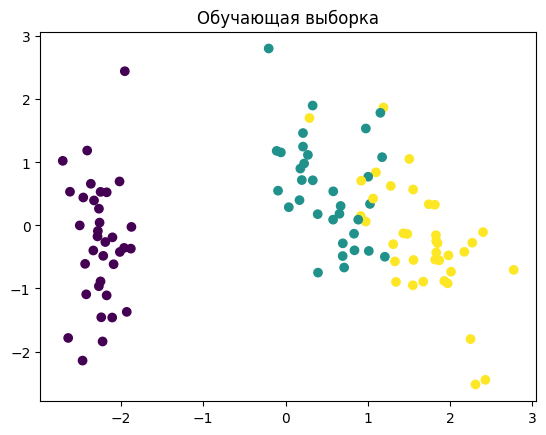

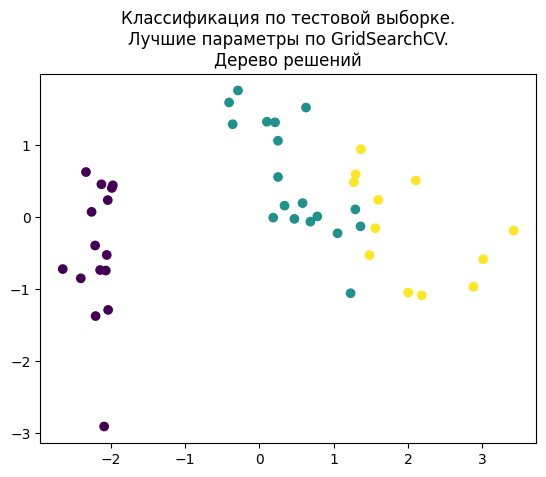

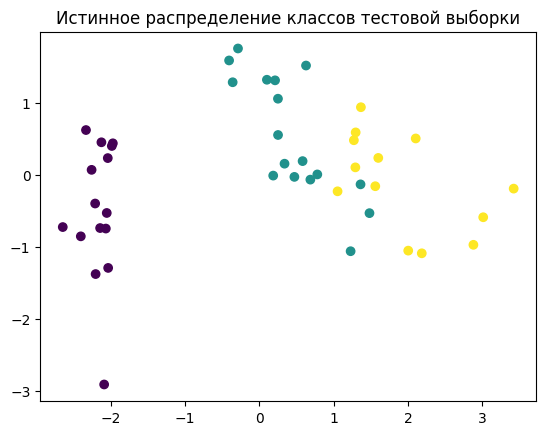

In [298]:
#punkt_4
y_pred=best_clf.predict(X_test)

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nЛучшие параметры по GridSearchCV.\nДерево решений')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

Средние метрики для валидационных выборок
test_accuracy           0.946667
test_recall_micro       0.946667
test_recall_macro       0.950000
test_precision_micro    0.946667
test_precision_macro    0.963889
test_f1_micro           0.946667
test_f1_macro           0.944444
dtype: float64 

Метрики по тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        16
           2       1.00      0.93      0.96        14

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



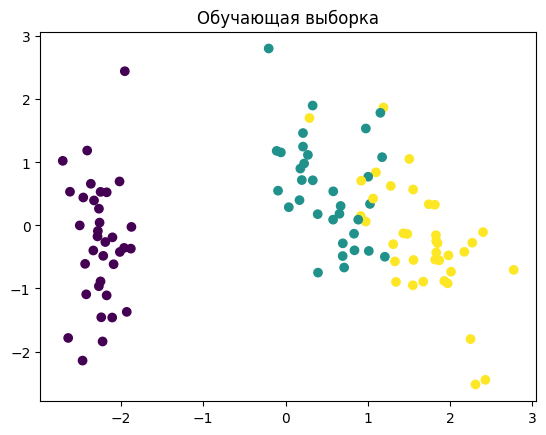

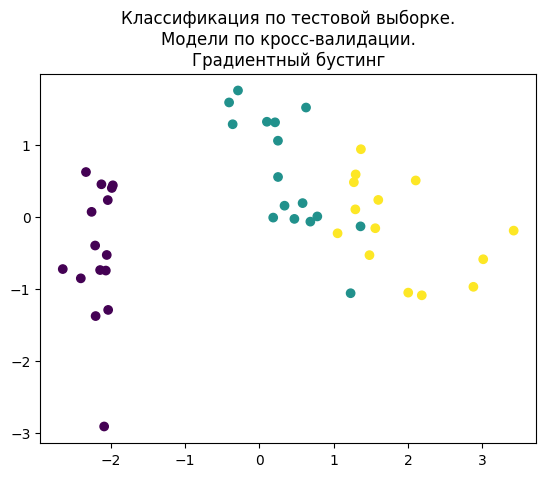

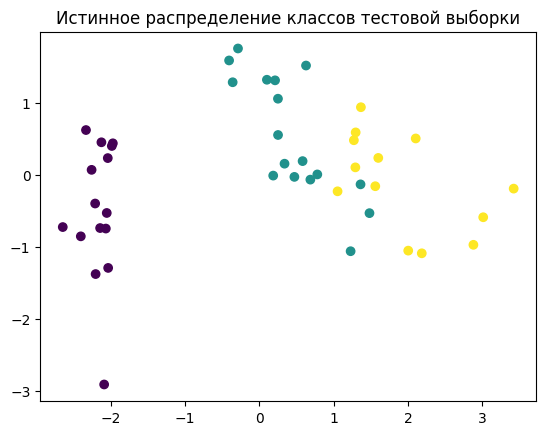

In [299]:
from catboost import metrics
custom_metric=[metrics.Accuracy(), metrics.F1(), metrics.Precision(), metrics.Recall()]

clf = CatBoostClassifier(
    random_seed=0,
    verbose=False, #объем выводимой информации (False - подавляем сообщения)
    depth=1,
    iterations=10
)
cross_validation_res = cross_validate(clf, X_train, y_train, cv = 20, scoring = scores1, return_estimator=True)
scores=pd.DataFrame(cross_validation_res).drop(['fit_time', 'score_time', 'estimator'], axis=1).mean(axis=0)
models = cross_validation_res['estimator']
y_pred = models_predict(models, X_test, n_classes)
print('Средние метрики для валидационных выборок')
print(scores, '\n')

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nМодели по кросс-валидации.\nГрадиентный бустинг')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

In [300]:
#punkt_3

clf = CatBoostClassifier(
    random_seed=0,
    verbose=False,
    custom_metric = custom_metric
)
params = {'learning_rate': np.arange(0.03, 0.1, 0.01),
          'iterations': range(2, 10),
        'depth': range(2,6),
        'l2_leaf_reg': [1, 2]}

import os
import sys
a = sys.stdout
f = open(os.devnull, 'w')
grig_clf = clf.grid_search(params,X_train,y=y_train,cv=6,verbose=False,log_cout=f)
f.close()
print('Найденные лучшие параметры')
print_dic(grig_clf.get('params'))

Найденные лучшие параметры
depth           -          3
l2_leaf_reg     -          1
iterations      -          9
learning_rate   -        0.1



Метрики по тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      0.94      0.94        17
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



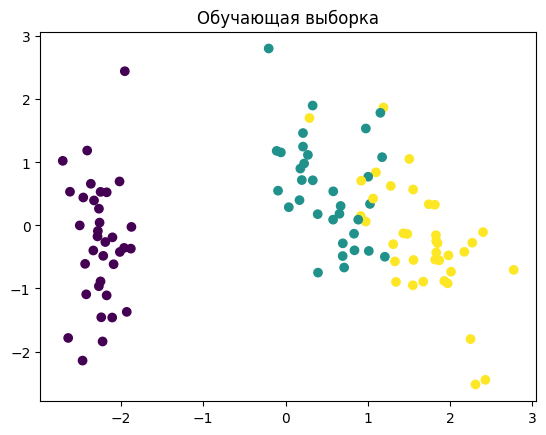

c:\Python311\Lib\site-packages\matplotlib\cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)


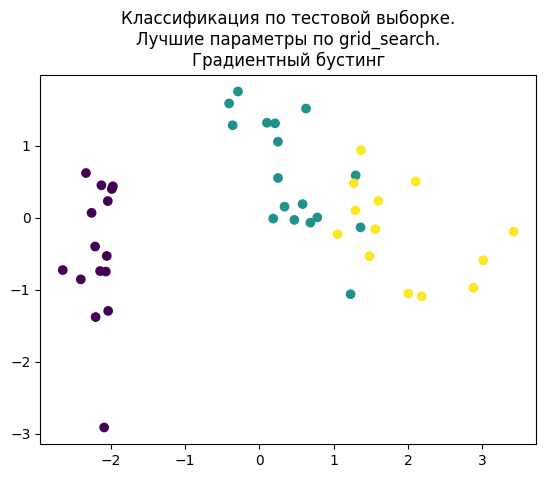

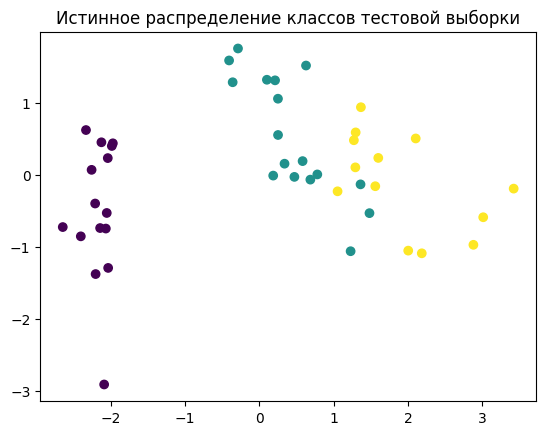

In [301]:
#punkt_4

best_clf = CatBoostClassifier(
    random_seed=0,
    verbose=False,
    custom_metric = custom_metric,
    **{'depth': 2, 'iterations': 9, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
)
best_clf.fit(X_train, y_train)
y_pred=best_clf.predict(X_test)

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nЛучшие параметры по grid_search.\nГрадиентный бустинг')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

Средние метрики для валидационных выборок
test_accuracy           0.955000
test_recall_micro       0.955000
test_recall_macro       0.958333
test_precision_micro    0.955000
test_precision_macro    0.969444
test_f1_micro           0.955000
test_f1_macro           0.953333
dtype: float64 

Метрики по тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        16
           2       1.00      0.93      0.96        14

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



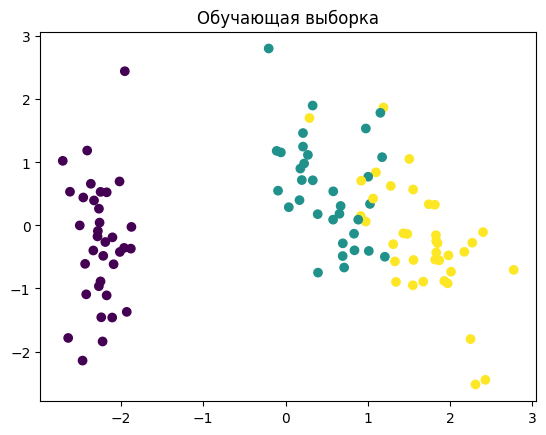

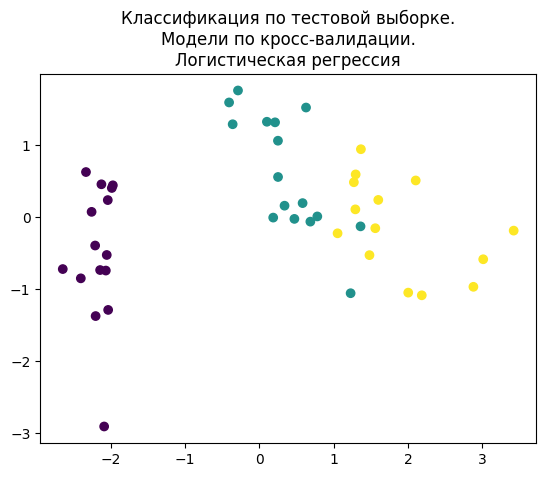

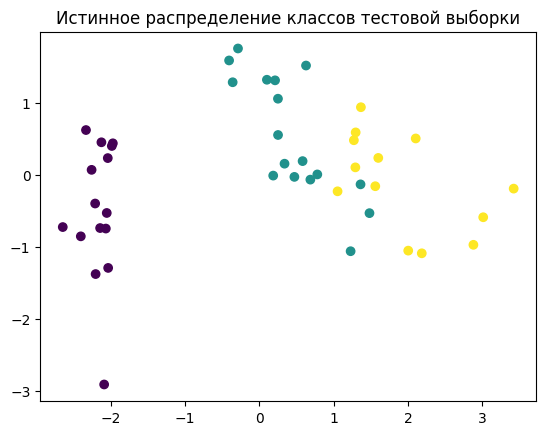

In [302]:
clf = LogisticRegression(random_state=0, max_iter = 151)
cross_validation_res = cross_validate(clf, X_train, y_train, cv = 20, scoring = scores1, return_estimator=True)
scores=pd.DataFrame(cross_validation_res).drop(['fit_time', 'score_time', 'estimator'], axis=1).mean(axis=0)
models = cross_validation_res['estimator']
y_pred = models_predict(models, X_test, n_classes)
print('Средние метрики для валидационных выборок')
print(scores, '\n')

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nМодели по кросс-валидации.\nЛогистическая регрессия')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

In [303]:
#punkt_3

clf = LogisticRegression(random_state=0, max_iter = 10000)
params = {'penalty':['l2', None],
          'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}

from sklearn.utils._testing import ignore_warnings 
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning 
from sklearn.model_selection import GridSearchCV 
grig_clf = GridSearchCV(clf, params, cv=20,error_score = np.nan)
with ignore_warnings(category=[ConvergenceWarning, FitFailedWarning]): 
    
    grig_clf.fit(X_train, y_train)

print('Найденные лучшие параметры модели')
print_dic(grig_clf.best_params_)
print(f'Оценка качества для лучшей модели {grig_clf.best_score_*100:.2f}%')
best_clf = grig_clf.best_estimator_

Найденные лучшие параметры модели
penalty         -       None
solver          -        sag

Оценка качества для лучшей модели 97.17%


Метрики по тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



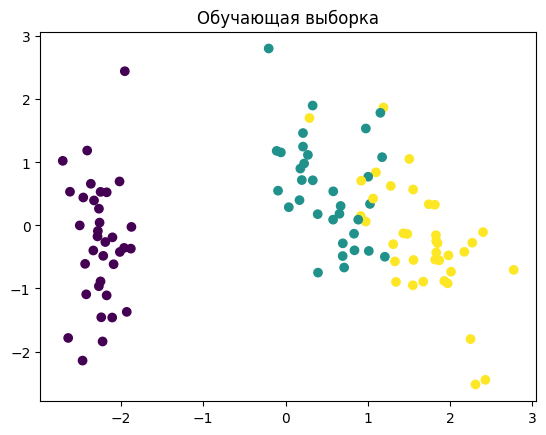

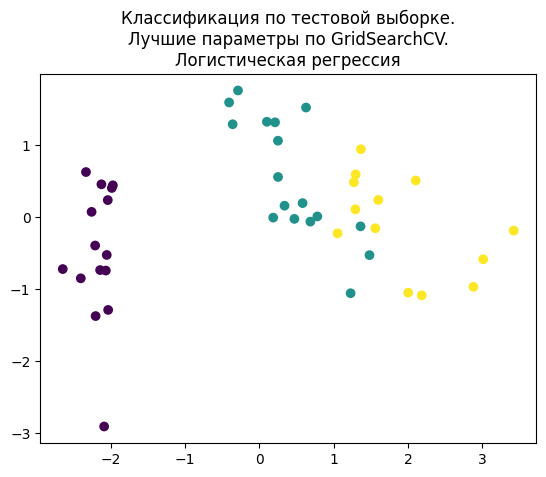

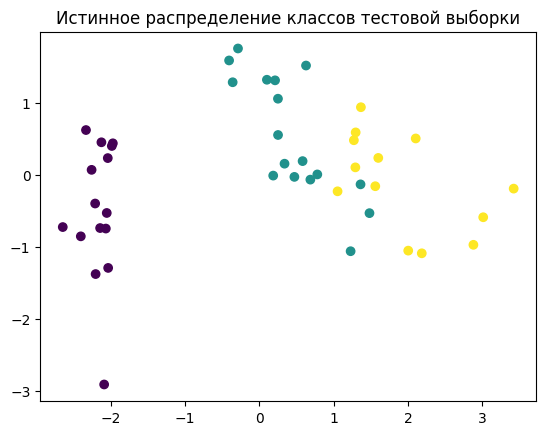

In [304]:
y_pred=best_clf.predict(X_test)

print('Метрики по тестовой выборке')
print(classification_report(y_pred, y_test)) 

plt.scatter(x='f1', y='f2', data=x_pca_pd, c=y_train)
plt.title('Обучающая выборка')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_pred)
plt.title('Классификация по тестовой выборке.\nЛучшие параметры по GridSearchCV.\nЛогистическая регрессия')
plt.show()


plt.scatter(x='f1', y='f2', data=x_test_pca_pd, c=y_test)
plt.title('Истинное распределение классов тестовой выборки')
plt.show()

   LONGITUD  LATITUDE  CLASS
0      59.0        17      0
1      59.5        21      0
2      60.0        12      0
3      60.5        16      0
4      61.0        13      0
5      61.0        15      0
6      61.5        17      0
7      61.5        19      0
8      62.0        14      0
9      63.0        15      1
        LONGITUD   LATITUDE      CLASS
count  37.000000  37.000000  37.000000
mean   65.432432  16.216216   0.486486
std     3.438269   2.709399   0.506712
min    59.000000  12.000000   0.000000
25%    63.000000  14.000000   0.000000
50%    65.500000  16.000000   0.000000
75%    68.000000  18.000000   1.000000
max    71.500000  21.000000   1.000000


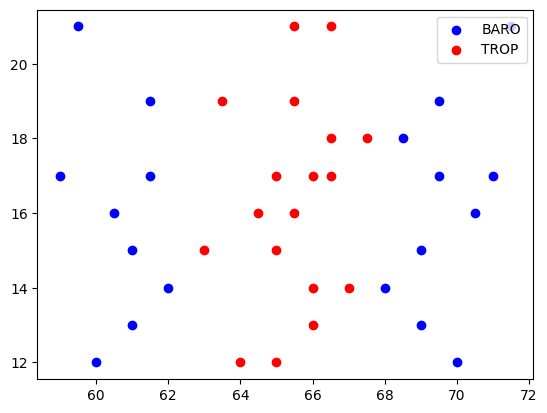

In [305]:
data_pd=pd.read_csv('Barotrop_formatted.csv', sep=';', decimal=',')

baro_trop_dic = {
    'BARO': 0,
    'TROP': 1
}

print(data_pd.head(10))
print(data_pd.describe())

target = data_pd['CLASS']
plt.scatter(x='LONGITUD', y='LATITUDE', data=data_pd.where(data_pd['CLASS'] == 0), c='b')
plt.scatter(x='LONGITUD', y='LATITUDE', data=data_pd.where(data_pd['CLASS'] == 1), c='r')
plt.legend(baro_trop_dic.keys())
plt.show()

Классы не являются линейно разделимыми (по крайней мере одной прямой), однако визуально видно, что их можно классифицировать, поскольку классы образуют четкие группы.